In [28]:
from NeuralNetworks.activationfunctions import *
from NeuralNetworks.numerical_integration import *
from NeuralNetworks.pHNN import *
from NeuralNetworks.Train import *

from Systems.HeatEquation import *
from Systems.generate_data import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.linalg import lu_factor, lu_solve

## The average vector field (AVF) integrator for the 1D heat equation

We consider the one–dimensional heat equation
$$
u_t = u_{xx}, \qquad x \in [0,L], \quad t>0,
$$
subject to Dirichlet boundary conditions \(u(0,t)=u(L,t)=0\).



### Reformulation

The PDE can be written on the form
$$
\dot{u} = N \nabla H(u),
$$
where $N$ is a negative–definite operator and $H(u)$ is a Lyapunov function.
Two equivalent formulations exist:

1. $N_1 = -I,\quad H_1(u) = \tfrac12\int_0^L |u_x|^2\,dx,$
2. $N_2 = \partial_{xx},\quad H_2(u) = \tfrac12\int_0^L |u|^2\,dx.$

Both lead to the same evolution equation $u_t = u_{xx}$ and both energies $H_1$ and $H_2$
are decreasing.




### Semi–discrete system

After spatial discretisation on a uniform grid $x_j=j\Delta x \quad j=0,\ldots,N$ applying a central difference scheme on the laplacian, we obtain
the tridiagonal matrix

$$
A = \frac{1}{(\Delta x)^2}\operatorname{tridiag}(1,-2,1),
$$
yielding the semi–discrete system 
$$
\dot{\mathbf{u}} = A\,\mathbf{u}.
$$


The discrete Lyapunov functions are
$$
H_1(\mathbf{u}) = \tfrac12\,\mathbf{u}^\top(-A)\mathbf{u},
\qquad
H_2(\mathbf{u}) = \tfrac12\,\mathbf{u}^\top\mathbf{u}.
$$




### Average Vector Field (AVF) time discretisation

For the system $\dot{\mathbf{u}} = A\mathbf{u}$,  
the AVF scheme is
$$
\frac{\mathbf{u}^{n+1}-\mathbf{u}^n}{\Delta t}
= \int_0^1 A\!\left((1-\xi)\mathbf{u}^n + \xi \mathbf{u}^{n+1}\right)d\xi.
$$
Since $A$ is linear, the integral simplifies to
$$
\frac{\mathbf{u}^{n+1}-\mathbf{u}^n}{\Delta t}
= A\frac{\mathbf{u}^{n+1}+\mathbf{u}^n}{2},
$$
which yields the update rule 
$$
\boxed{(I - \tfrac{\Delta t}{2}A)\mathbf{u}^{n+1}
       = (I + \tfrac{\Delta t}{2}A)\mathbf{u}^n.}
$$





### Numerical setup

- Domain: $x\in[0,L]$ with $L=1$
- Grid: $N$ subintervals, $\Delta x = L/N$
- Boundary conditions: $u(0)=u(L)=0$
- Initial condition: $u(x,0)=x(1-x)$

The AVF update
$$
(I - \tfrac{\Delta t}{2}A)\mathbf{u}^{n+1}
  = (I + \tfrac{\Delta t}{2}A)\mathbf{u}^{n}
$$
is solved each step using an LU factorisation of the constant matrix $(I - \tfrac{\Delta t}{2}A)$.


In [29]:
#L=1.0
#N=20
#T=0.25
#dt=0.0025

#sys = HeatEquation(N = N, L=L, dt=dt, T=T)


#u0 = sys._initial_condition_sampler()
#u0

In [30]:
L=1.0
N=40
T=0.25
dt=0.0025

sys = HeatEquation(N = N, L=L, dt=dt, T=T)

integrator = "AVF"
ntraj_train = 1
t_train = np.linspace(0, T, int(1/dt))



100%|██████████| 1/1 [00:00<00:00, 234.31it/s]


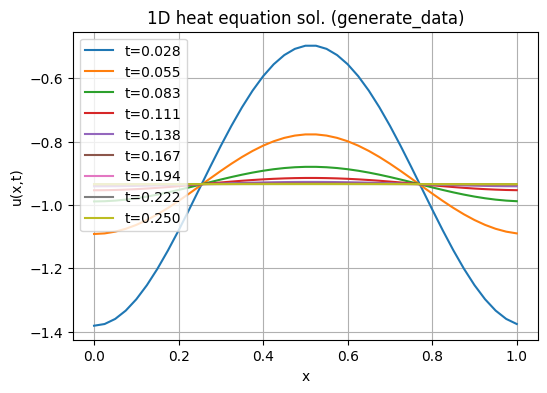

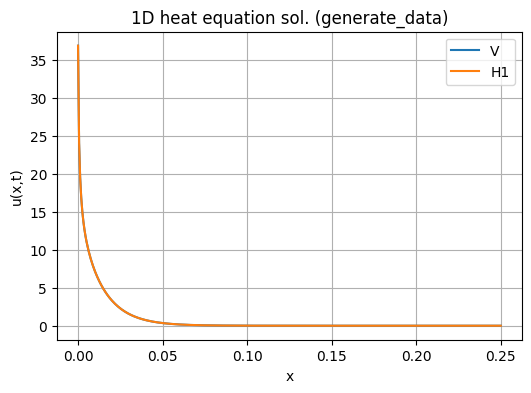

In [31]:
(u_start, u_end, t_start,t_end, dt, xspatial), dudt_tensor, u, u0_  =  generate_data_PDE(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator)


x = sys.x
t = t_train
U = u[0]


n_plot = min(10, len(t))
indices = np.linspace(0, len(t) - 1, n_plot, dtype=int)

plt.figure(figsize=(6, 4))
for i in indices:
    if i > 0:
        plt.plot(x, U[i], label=f"t={t[i]:.3f}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("1D heat equation sol. (generate_data)")
plt.legend()
plt.grid(True)
plt.show()

V_d = []
u_copy = u.copy()
dx = sys.dx
A = sys.A
H1 = [0.5 * u.T @ (-A) @ u * dx for u in U]
H2 = [0.5 * np.sum(u[0:-1]**2) * dx   for u in U]
for u_d in u_copy[0]:
    Vi =sys.V(np.array([u_d]))*(-sys.dx)
    V_d.append(Vi[0])

V_d =np.array(V_d)
plt.figure(figsize=(6, 4))
plt.plot(t, V_d, label=f"V")
plt.plot(t, H1, label=f"H1")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("1D heat equation sol. (generate_data)")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
L=1.0
#N = 40
#T=0.25
#dt = 0.0025

N = 40
T = 0.25
dt =  0.0025

sys = HeatEquation(N = N, L=L, dt=dt, T=T)
init_sampler = lambda rng=None: sys._initial_condition_sampler(rng)

integrator = "midpoint"
ntraj_train = 140
t_train = np.linspace(0, T, int(T/dt)+1)

ntraj_val =60
t_val = np.linspace(0, T, int(T/dt)+1)

(u_start, u_end, t_start, t_end,  dt, xspatial), dudt_tensor, u_train, u0s_train  =  generate_data_PDE(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator)
train_data = (u_start, u_end,t_start, t_end, dt, xspatial), dudt_tensor

(u_start, u_end, t_start, t_end, dt, xspatial), dudt_tensor, u_val, u0s_val  =  generate_data_PDE(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator)
val_data = (u_start, u_end,t_start, t_end, dt, xspatial), dudt_tensor


100%|██████████| 60/60 [00:00<00:00, 61.26it/s]


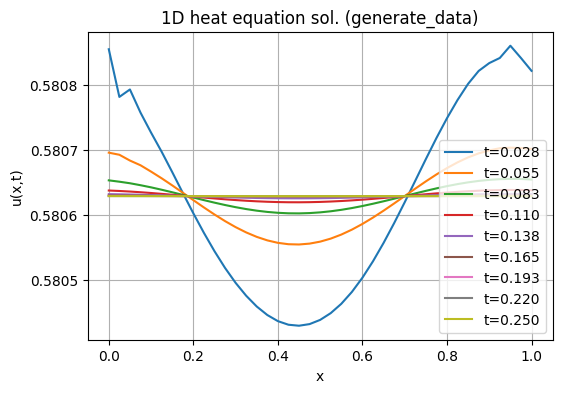

In [33]:
x = sys.x
t = t_train

import random 
j = random.randint(0, ntraj_train-1)
U = u_train[j]


n_plot = min(10, len(t))
indices = np.linspace(0, len(t) - 1, n_plot, dtype=int)

plt.figure(figsize=(6, 4))
for i in indices:
    if i > 0:
        plt.plot(x, U[i], label=f"t={t[i]:.3f}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("1D heat equation sol. (generate_data)")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
#A = torch.tensor(np.array([[[1]]]),dtype=torch.float32)
#S = torch.tensor(np.array([[[0, 0, 0]]]),dtype=torch.float32)
#R = torch.tensor(np.array([[[1]]]),dtype=torch.float32)

#A, S, R = None, None, None
nstates = sys.nstates
A = torch.tensor([[[1.0]]], dtype=torch.float32)   # conv kernel len=1 (identity)
R = torch.tensor([[[1.0]]], dtype=torch.float32)   # conv kernel len=1
S = None

S = sys.skewsymmetric_matrix_flat

100%|██████████| 200/200 [49:35<00:00, 14.88s/it, epoch=199, loss=0.000842]


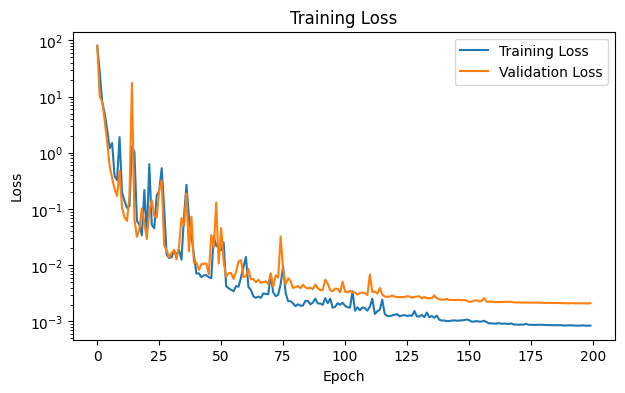

In [35]:
lr = 1e-3
epochs = 200
batch_size = 64
loss_func = torch.nn.MSELoss()

kernel_sizes = [1, 0, 1, 0]

model = PDE_PHNN(nstates = sys.nstates, kernel_sizes=kernel_sizes, A = A, S = S, R = R)
#optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

trainer = Training(model = model,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer, system = sys, batch_size=batch_size,epochs = epochs)
model, trainingdetails = trainer.train(loss_func=loss_func,scheduler=scheduler)

In [36]:
T=0.25
dt=0.0025

sys = HeatEquation(N = N, L=L, dt=dt, T=T)
init_sampler = lambda rng=None: sys._initial_condition_sampler(rng)

integrator = "midpoint"
ntraj_test = 100
t_test = np.linspace(0, T, int(1/dt))



(u_start, u_end, t_start, t_end, dt, xspatial), dudt_tensor, u_test, u0s_test  =  generate_data_PDE(system=sys,ntrajectories =ntraj_test, t_sample = t_test,integrator=integrator)
test_data = (u_start, u_end,t_start, t_end, dt, xspatial), dudt_tensor

100%|██████████| 100/100 [00:09<00:00, 10.99it/s]


In [ ]:

def simulate_trajectory(model, t_sample,u0=None, xspatial=None):
    u0 = torch.tensor(u0)
    if u0 is None:
        u0 = model._initial_condition_sampler(1)

    if model.kernel_sizes[0] == 1:
        if xspatial is not None:
            def u_dot(t, u):
                u = torch.tensor(u.reshape(1, u.shape[-1]), dtype=torch.float32)
                t = torch.tensor(np.array(t).reshape((1, 1)), dtype=torch.float32)
                xspatial =torch.tensor(np.array(xspatial).reshape(1, xspatial.shape[-1]), dtype=torch.float32)
                return model.u_dot(u,t,xspatial=xspatial).detach().numpy().flatten()

        else:
            def u_dot(t, u):
                u = torch.tensor(u.reshape(1, u.shape[-1]), dtype=torch.float32)
                t = torch.tensor(np.array(t).reshape((1, 1)), dtype=torch.float32)
                return model.u_dot(u,t).detach().numpy().flatten()
   
    out_ivp = solve_ivp(fun=u_dot,t_span=(t_sample[0], t_sample[-1]),y0=u0.detach().numpy().flatten(),t_eval=t_sample,rtol=1e-10)
    U = out_ivp["y"].T
    return U, None



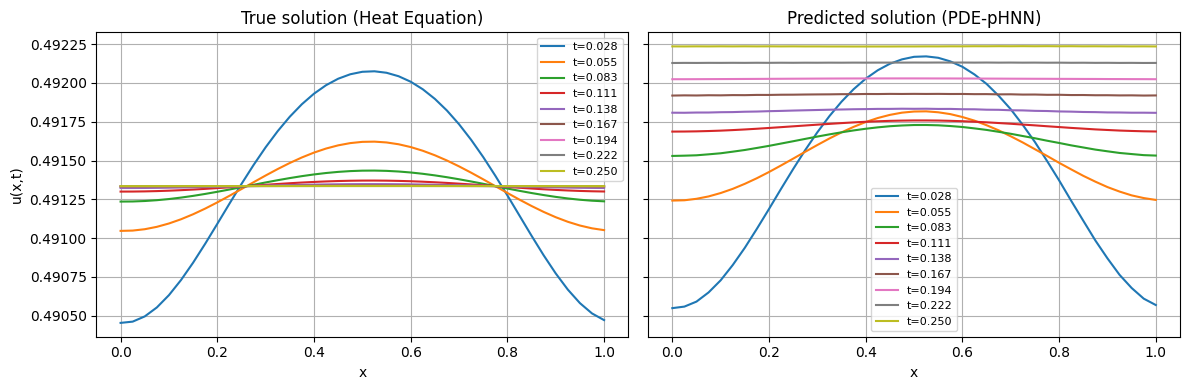

In [40]:
x = sys.x
i = random.randint(0,ntraj_test-1)
U, _ =  model.simulate_trajectory(t_test,u0=u0s_test[i], xspatial=None)

t = t_test         
U_true = u_test[i]#.squeeze(0)     

Nt_pred, Nx_pred = U.shape
Nt_true, Nx_true = U_true.shape

Nt = min(Nt_pred, Nt_true, len(t))
Nx = min(Nx_pred, Nx_true, len(x))

U = U[:Nt, :Nx]
U_true = U_true[:Nt, :Nx]
x_plot = x[:Nx]
t_plot = t[:Nt]


n_plot = min(10, Nt)
indices = np.linspace(0, Nt - 1, n_plot, dtype=int)


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)


for i in indices:
    if i > 0:
        axes[0].plot(x_plot, U_true[i], label=f"t={t_plot[i]:.3f}")
axes[0].set_title("True solution (Heat Equation)")
axes[0].set_xlabel("x")
axes[0].set_ylabel("u(x,t)")
axes[0].grid(True)
axes[0].legend(fontsize=8)


for i in indices:
   if i > 0:
        axes[1].plot(x_plot, U[i], label=f"t={t_plot[i]:.3f}")
axes[1].set_title("Predicted solution (PDE-pHNN)")
axes[1].set_xlabel("x")
axes[1].grid(True)
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
#model, _, _ = load_model(path = "Models/HeatEquation/HeatEquation_midpoint_150epoch_batchsize_32_shape_torch.Size([10000, 1, 41]).pt" )


In [ ]:
# flip sign of dV (bound-method safe)
#model.dV = (lambda _orig: (lambda u: -_orig(u)))(model.dV)
#model.R = -model.R
# unflip (wrap again to re-negate)
#model.dV = (lambda _orig: (lambda u: -_orig(u)))(model.dV)
